In [ ]:
#Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
validation_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/validation_OH.csv', low_memory=False)

In [ ]:
training_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/training_OH.csv', low_memory=False)

In [ ]:
test_set = pd.read_csv('/content/drive/MyDrive/Thesis Dataset/test_OH.csv', low_memory=False)

In [ ]:
test_set.isnull().sum()

ID                                           0
Age                                          0
Global_Score_pro                             0
one_hot_encoder__Nationality_COLOMBIA        0
one_hot_encoder__Gender_F                    0
                                            ..
one_hot_encoder__Internet_Access_Change_1    0
one_hot_encoder__Internet_Access_Change_2    0
one_hot_encoder__Working_Hours_Change_0      0
one_hot_encoder__Working_Hours_Change_1      0
one_hot_encoder__Working_Hours_Change_2      0
Length: 235, dtype: int64

In [ ]:
# Ordering columns in both datasets
training_columns = training_set.columns.tolist()
validation_columns = validation_set.columns.tolist()

if training_columns != validation_columns:
    validation_set = validation_set.reindex(columns=training_columns)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Define features and target variable for training set
X_train = training_set.drop(columns=['ID', 'Global_Score_pro'])
y_train = training_set['Global_Score_pro']

# Define features and target variable for validation set
X_valid = validation_set.drop(columns=['ID', 'Global_Score_pro'])
y_valid = validation_set['Global_Score_pro']

# Train decision tree regressor with limited max depth
model = DecisionTreeRegressor(max_depth=7, random_state=42)
model.fit(X_train, y_train)

# Predict on training set
y_pred_train = model.predict(X_train)

# Predict on validation set
y_pred_valid = model.predict(X_valid)

# Calculate Mean Squared Error (MSE) on training set
mse_train = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE) on training set:", mse_train)

# Calculate Mean Squared Error (MSE) on validation set
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print("Mean Squared Error (MSE) on validation set:", mse_valid)

Mean Squared Error (MSE) on training set: 463.56914041376353
Mean Squared Error (MSE) on validation set: 470.6150642650433


In [ ]:
# Define features for test set
X_test = test_set.drop(columns=['ID', 'Global_Score_pro'])

# Predict on test set
y_test_pred = model.predict(X_test)

# Obtain true target values for the test set
y_test = test_set['Global_Score_pro']

# Calculate Mean Squared Error (MSE) on test set
mse_test = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error (MSE) on test set:", mse_test)

Mean Squared Error (MSE) on test set: 471.6614351951987


In [ ]:
# Save the predictions and the true values to a CSV file
test_results = pd.DataFrame({
    'ID': test_set['ID'],  # Assuming 'ID' is the identifier in your test set
    'True Values': y_test,
    'Predictions': y_test_pred
})

test_results.to_csv('/content/drive/MyDrive/Colab Notebooks/test_set_predictions_dt.csv', index=False)

print("Test set predictions have been saved to 'test_set_predictions.csv'")

Test set predictions have been saved to 'test_set_predictions.csv'


In [ ]:
noise_factor = 0.1
X_test_sample = X_test.sample(frac=0.3, random_state=42)  # Sample 30% of the test set
X_test_noisy_sample = X_test_sample + noise_factor * np.random.normal(size=X_test_sample.shape)
y_test_sample = y_test.loc[X_test_sample.index]
y_test_pred_noisy_sample = model.predict(X_test_noisy_sample)
mse_test_noisy_sample = mean_squared_error(y_test_sample, y_test_pred_noisy_sample)
print("MSE on noisy test sample:", mse_test_noisy_sample)

MSE on noisy test sample: 472.18132876230703


In [ ]:
# Get the feature importances
feature_importances = model.feature_importances_

# Convert feature importances to a DataFrame
importance_df = pd.Series(feature_importances, index=X_train.columns, name='Importance')

# Aggregate feature importances by variable names
aggregated_importance = importance_df.groupby(lambda x: x.replace('one_hot_encoder__', '').rsplit('_', 1)[0]).sum()

# Sort the aggregated importances in descending order
aggregated_importance = aggregated_importance.sort_values(ascending=False)

# Print aggregated feature importances
print("Aggregated Feature Importances:")
print(aggregated_importance)

Aggregated Feature Importances:
University_Tuition_Fee_pro            0.422654
Institution_Academic_Character_pro    0.190191
Housing_Stratum_pro                   0.100536
Institution_Origin_pro                0.072768
Student_Program_Method_pro            0.067248
Scholarship_Payment_pro               0.040655
Residence_Department_pro              0.033800
Institution_Department_pro            0.025648
Father_Education_pro                  0.012454
Age                                   0.011335
Residence_Area_pro                    0.008811
Group_Reference_pro                   0.008741
Weekly_Working_Hours_pro              0.001448
Mother_Education_pro                  0.000886
Video_Game_Console_Access_pro         0.000622
Mother_work_pro                       0.000521
Ethnicity                             0.000453
Shared_Bathroom_Count_pro             0.000408
Internet_Access_pro                   0.000325
Washing_Machine_Access_pro            0.000151
Father_work_pro             

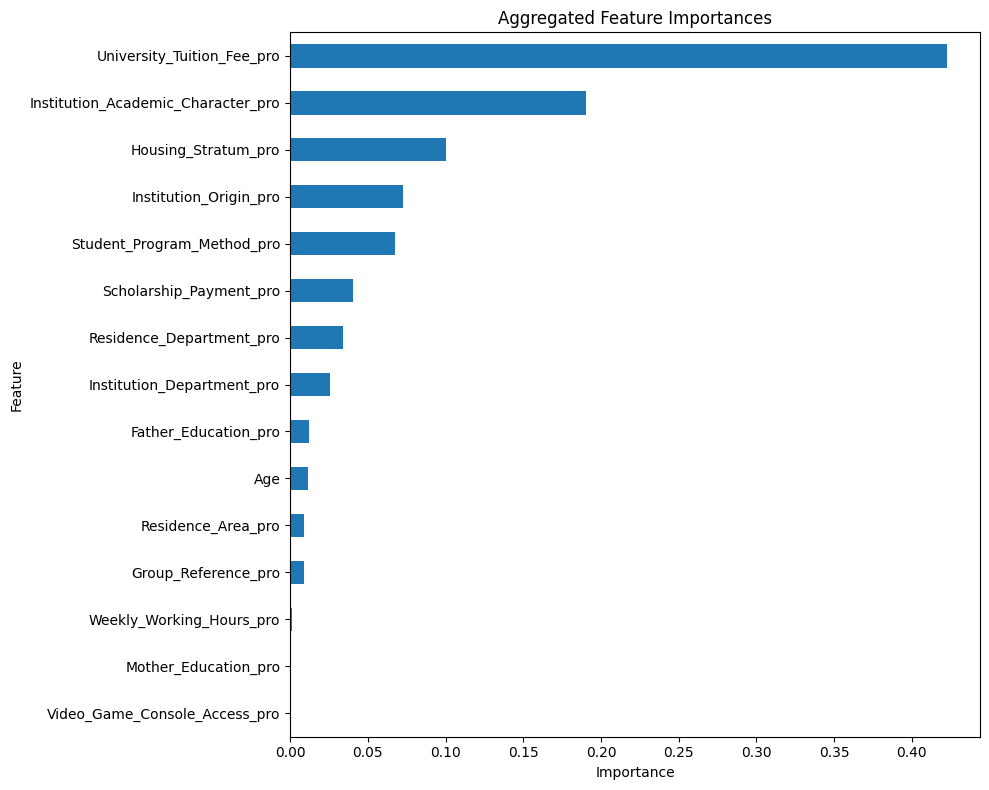

In [ ]:
# Select the top 15 most informative features and reverse the order
top_15_features = aggregated_importance.head(15)[::-1]

# Plotting the aggregated feature importances as horizontal bars
plt.figure(figsize=(10, 8))
top_15_features.plot(kind='barh')
plt.title('Aggregated Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Images/DTfeatureimportances.jpg', dpi=300)
plt.show()

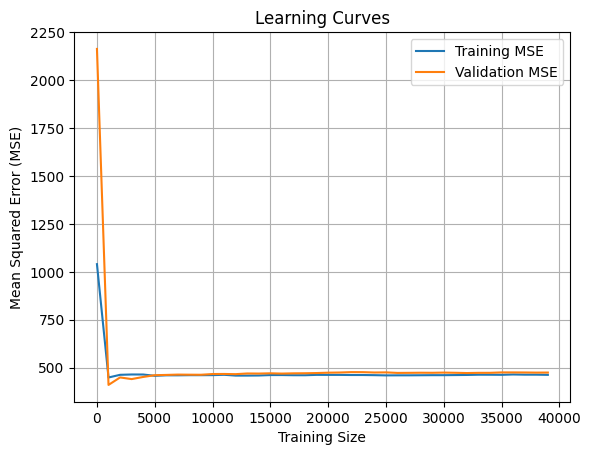

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define a range of training sizes
training_sizes = np.arange(1, 40001, 1000)  # From 1 to 40,000 with steps of 1000

# Initialize lists to store MSE values for each set
mse_train_sizes = []
mse_valid_sizes = []

# Vary the dataset size and collect MSE values
for dataset_size in training_sizes:
    # Subset the data to the current dataset size
    X_train_subset = X_train[:dataset_size]
    y_train_subset = y_train[:dataset_size]
    X_valid_subset = X_valid[:dataset_size]
    y_valid_subset = y_valid[:dataset_size]

    # Predict using the already trained model
    y_pred_train_subset = model.predict(X_train_subset)
    y_pred_valid_subset = model.predict(X_valid_subset)

    # Calculate MSE for each set
    mse_train = mean_squared_error(y_train_subset, y_pred_train_subset)
    mse_valid = mean_squared_error(y_valid_subset, y_pred_valid_subset)

    # Append MSE values
    mse_train_sizes.append(mse_train)
    mse_valid_sizes.append(mse_valid)

# Plot learning curves
plt.plot(training_sizes, mse_train_sizes, label='Training MSE')
plt.plot(training_sizes, mse_valid_sizes, label='Validation MSE')

plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()